### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

In [14]:
#libraries 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib.patches import Ellipse
from astroML.stats.random import bivariate_normal
from astroML.stats import fit_bivariate_normal
from astroML.resample import jackknife
from astroML.stats import sigmaG
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [16]:
data = np.load('hw_data/hw8_data_1.npy')
#colnames= 
print(data.dtype.names)
specNames = data['specClass']
u= data['u']
g=data['g']
r=data['r']
i=data['i']
z=data['z']

redshift= data['redshift']
redshift_err=data['redshift_err']

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


2.)Make a scatter plot of  versus , color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set xlim between -0.5 and 2.5, and ylim between -0.5 and 1.5.

['GALAXY' 'QSO']


/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_99809/4026676756.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


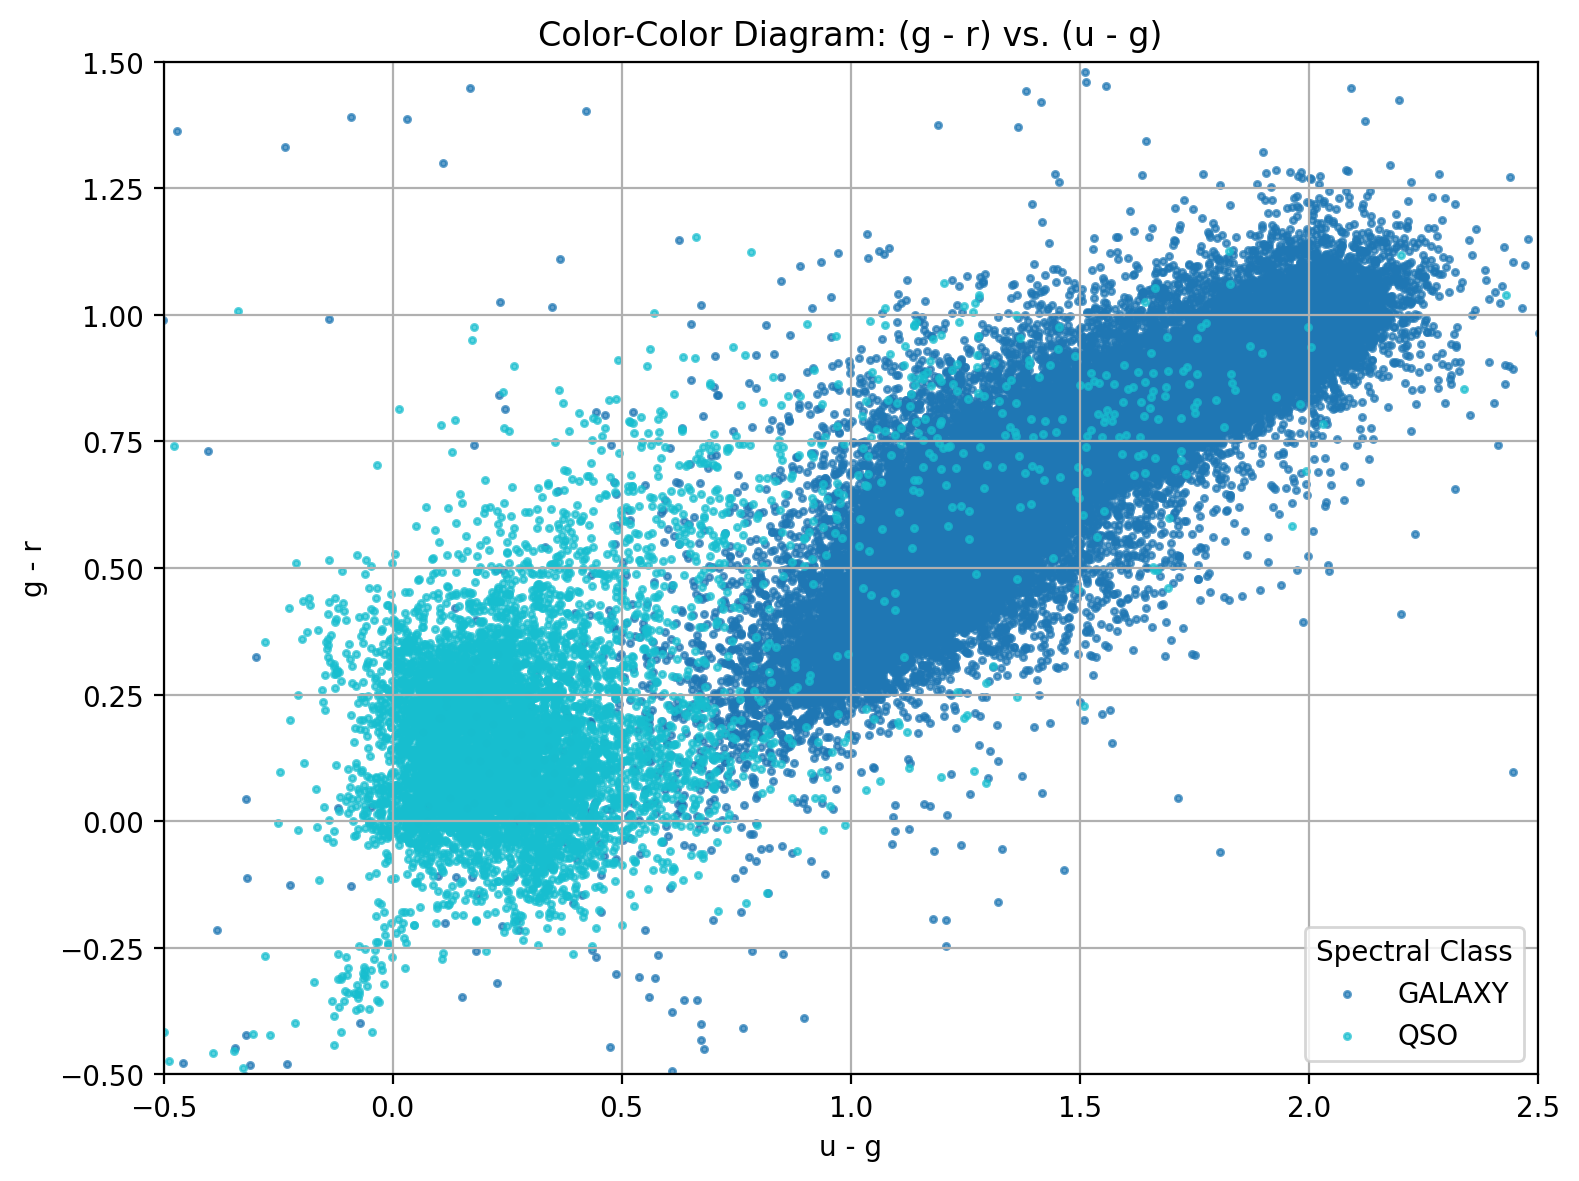

In [27]:
u_minus_g = u - g
g_minus_r = g - r

classes = np.unique(specNames)# quasar class. 
print(classes)

colors = plt.cm.get_cmap('tab10', len(classes))
color_map = {cls: colors(i) for i, cls in enumerate(classes)}

# Plot
plt.figure(figsize=(8, 6))
for cls in classes:
    mask = specNames == cls
    plt.scatter(u_minus_g[mask], g_minus_r[mask], s=5, color=color_map[cls], label=cls, alpha=0.7) #this plots the data and differentiates color_map[cls]

# Formatting
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('Color-Color Diagram: (g - r) vs. (u - g)')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend(title='Spectral Class')
plt.grid(True)
plt.tight_layout()
plt.show()

3.) Stack all colors and the redshift into a data matrix, . Create a target label array that has  for a regular galaxy and  for a quasar. Perform a train-test split, taking  of the data for testing.


In [48]:
from sklearn.model_selection import train_test_split

# Feature matrix: stack all colors and redshift
# Colors: u-g, g-r, r-i, i-z
features = np.column_stack([
    u - g,
    g - r,
    r - i,
    i - z,
    redshift
])
X=features
print(X)
# Target labels: 0 for galaxy, 1 for quasar
labels = np.where(specNames == 'QSO', 1, 0)

# Train-test split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)


[[  0.57029      0.04138     14.85225    -14.53599      2.312959  ]
 [  2.04144      0.98938     11.3018     -10.45467      0.05187586]
 [  1.84529      1.0416      11.97252    -11.11948      0.09769295]
 ...
 [  0.63545      0.08109     14.04838    -13.677        2.267401  ]
 [  0.30073      0.16404     14.9035     -14.82694      1.407278  ]
 [  0.5429       0.13127     14.69858    -14.43456      0.6865192 ]]


4.Create a compact for loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use xlim between 0 and 0.01. Which feature seems to make the classification trivially easy? Note: predict_proba returns an array with as many columns as classes. You've labeled quasars as , so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the classes_ attribute of the estimator.

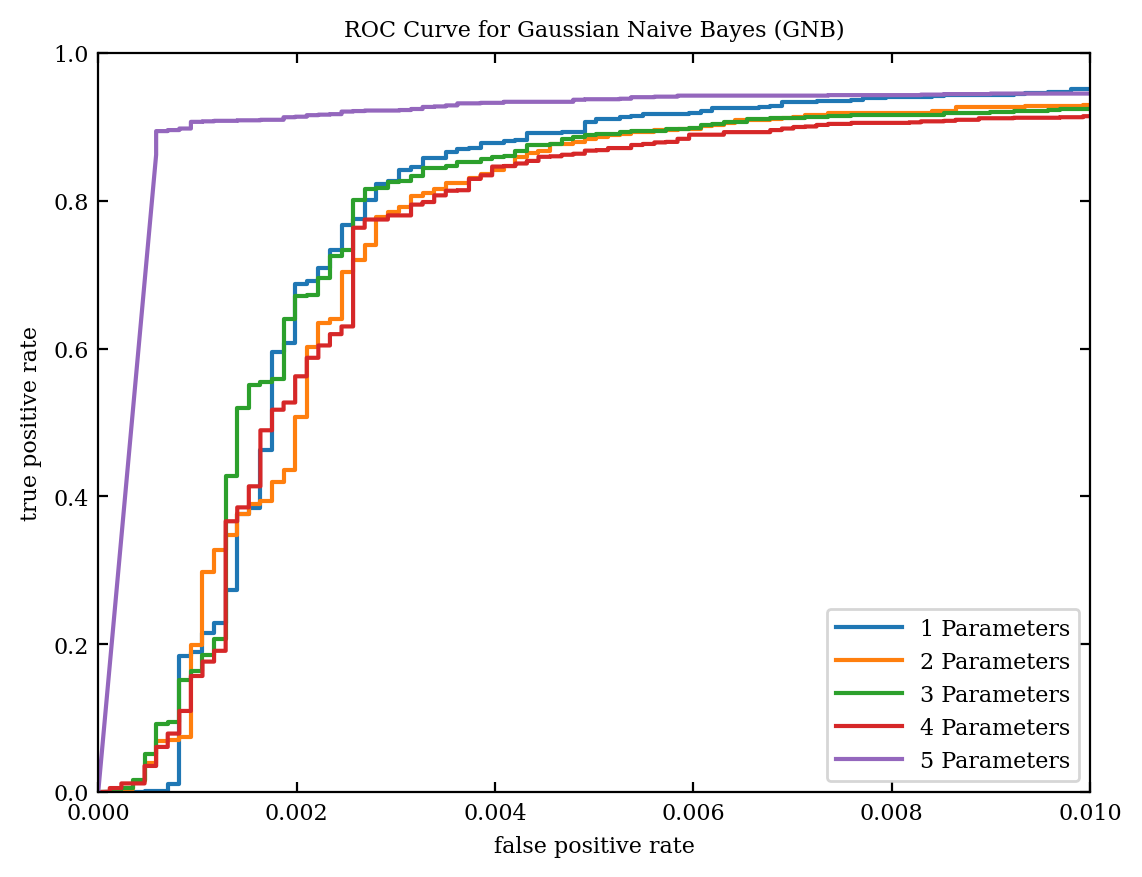

In [46]:
from astroML.plotting import setup_text_plots
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(X[0, :])): #Loop through columns of X
    gnb = GaussianNB()#Gaussian Naive Bayes classification algorithm to successively more features of the data.
    gnb.fit(X_train[:, :i+1],y_train) #Takes up to the (i+1)th coulmn
    y_pred = gnb.predict_proba(X_test[:,:i+1])[:,1] #Probability of QSO
    fpr, tpr, thresh = roc_curve(y_test, y_pred)#compute and plot an ROC curve
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"{i+1} Parameters")#plot

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for Gaussian Naive Bayes (GNB)")
plt.xlim(0,0.01)# Use xlim between 0 and 0.01.
plt.legend()
plt.show()

Using all 5 parameters with the Gaussian Naive Bayes model makes the classification very effective. The ROC curve with all features shows the highest true positive rate early on, meaning it identifies quasars quickly with very few false positives. This suggests the full feature set helps the model separate galaxies and quasars much more easily. -ALC

4.) Repeat (4) for Quadratic Discriminant Analysis.

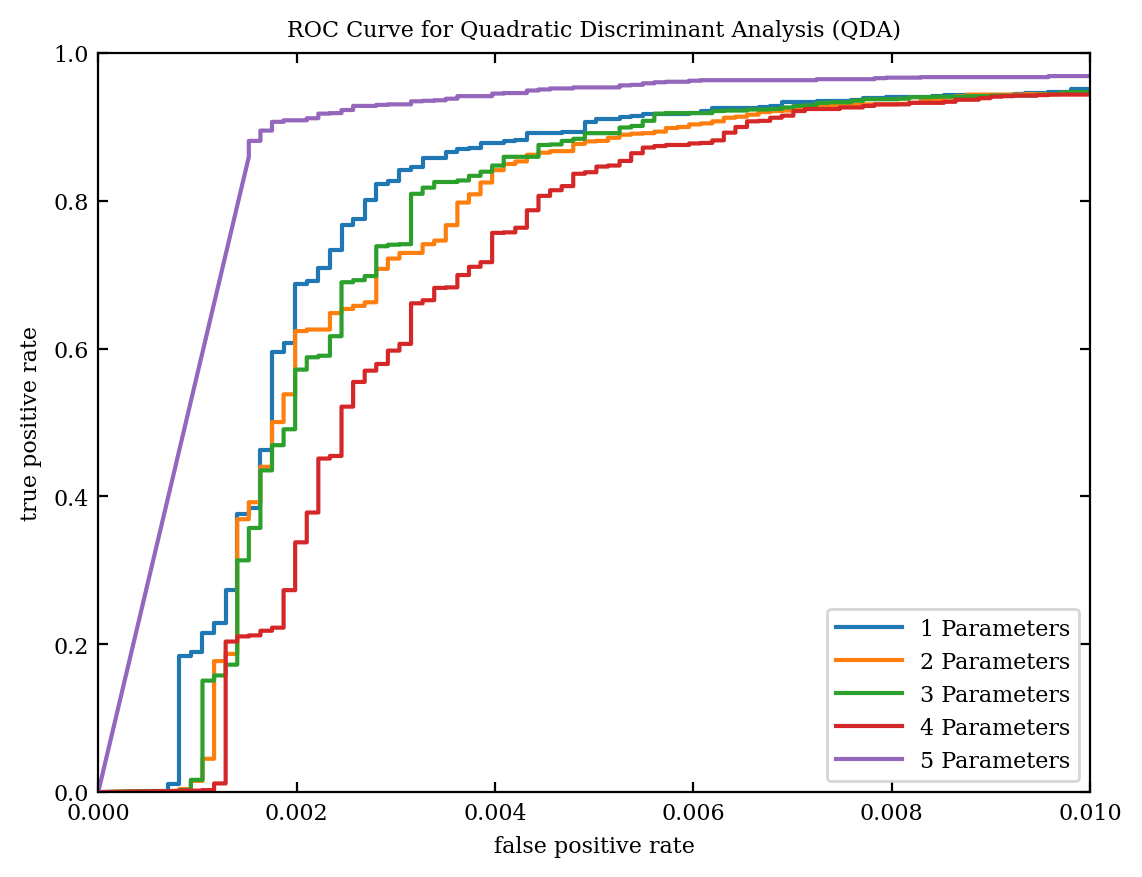

In [53]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
for i in range(len(X[0, :])): #Loop through columns of X
    qda = QDA() # the only thing that is changed
    qda.fit(X_train[:, :i+1],y_train)
    y_pred = qda.predict_proba(X_test[:,:i+1])[:,1] 
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    plt.plot(fpr, tpr, label=f"{i+1} Parameters")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for Quadratic Discriminant Analysis (QDA)")
plt.xlim(0,0.01)
plt.legend()
plt.show()

Similar results occure, however Gaussian Naive Bayes classification algorithm seems to classify quicker. -ALC

5.)Let's try classification with GMM Bayes. Restrict the training and testing to be just on the  colors. Iterate now over number of components in the GMM Bayes fit up to , plotting ROC curves for all, and find the number of components that gives the best performance.



<Figure size 800x600 with 0 Axes>

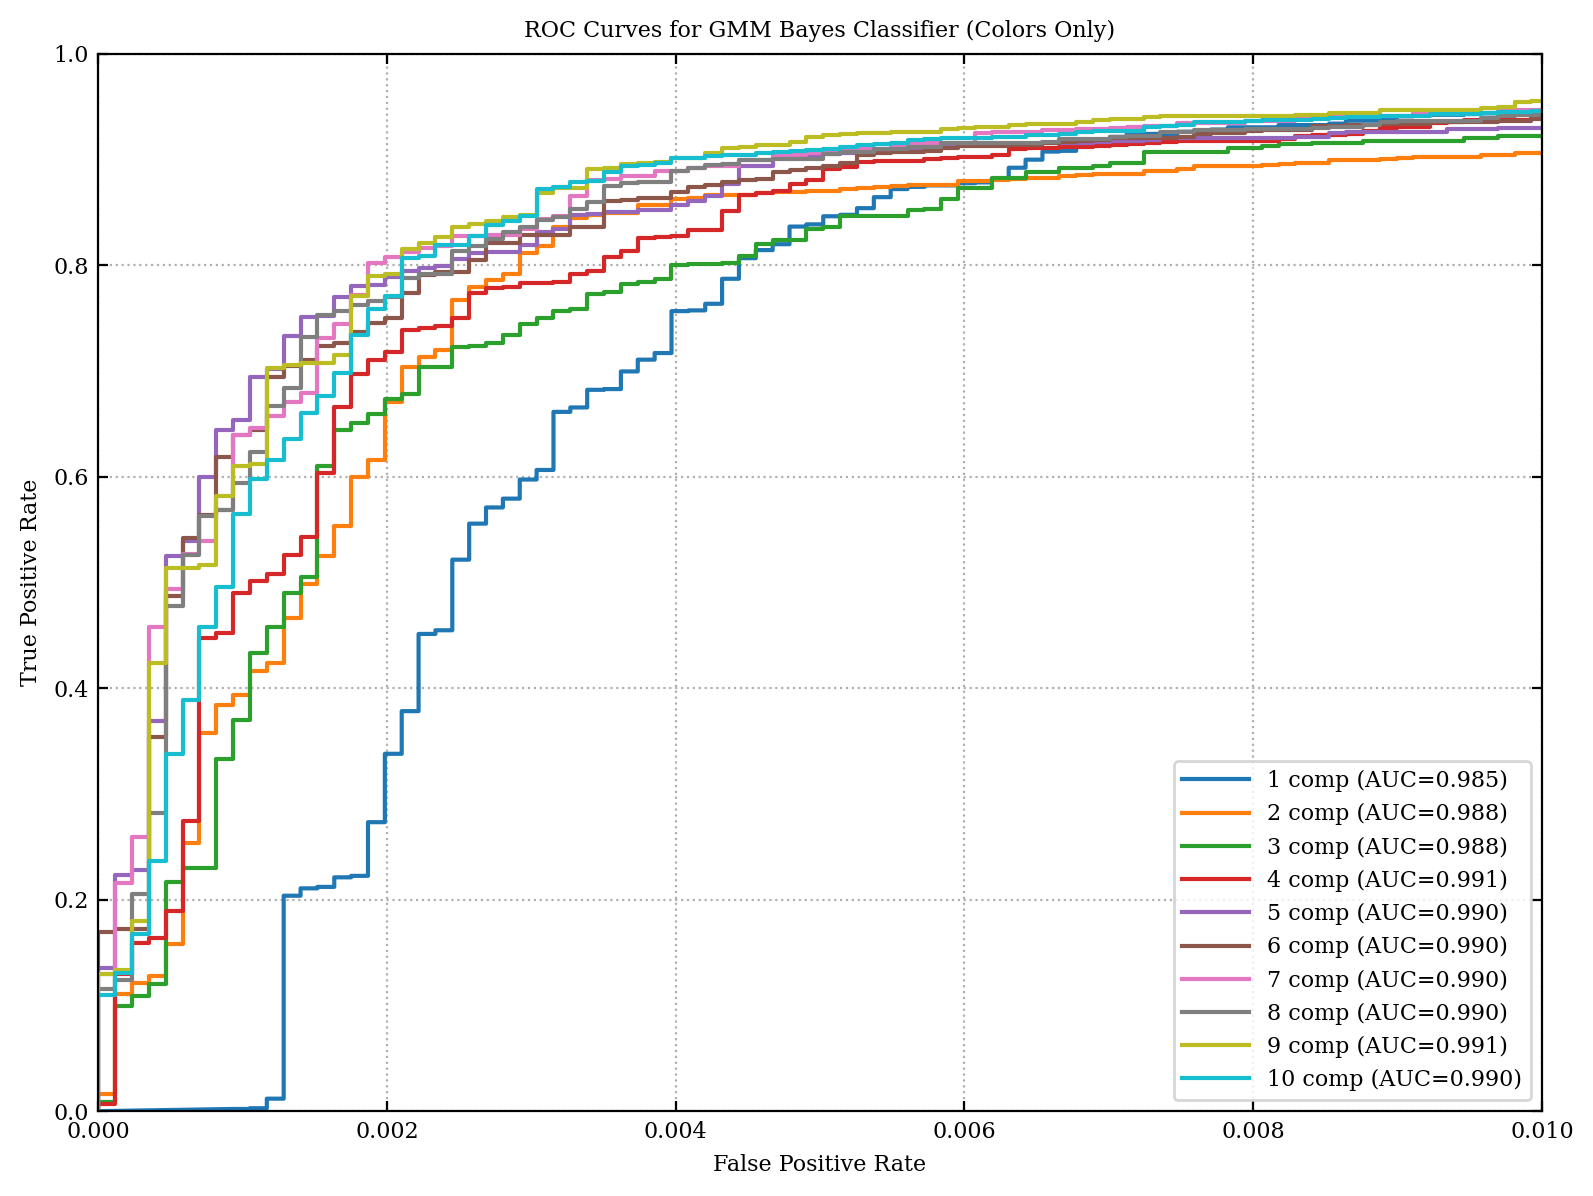

Best number of components: 4 with AUC = 0.991


In [63]:
from astroML.classification import GMMBayes
from sklearn.metrics import roc_curve, auc

components_range = range(1, 11)
plt.figure(figsize=(8, 6))

best_auc = 0
best_n = 1

for n_components in components_range:
    clf = GMMBayes(n_components=n_components)
    clf.fit(Xtrain_c, ytrain_c)

    # Find probability for quasar class (label 1)
    quasar_index = np.where(clf.classes_ == 1)[0][0]
    y_prob = clf.predict_proba(Xtest_c)[:, quasar_index]

    fpr, tpr, _ = roc_curve(ytest_c, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{n_components} comp (AUC={roc_auc:.3f})')

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_n = n_components

plt.title("ROC Curves for GMM Bayes Classifier (Colors Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best number of components: {best_n} with AUC = {best_auc:.3f}")

6.)Repeat (6) for -nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance.

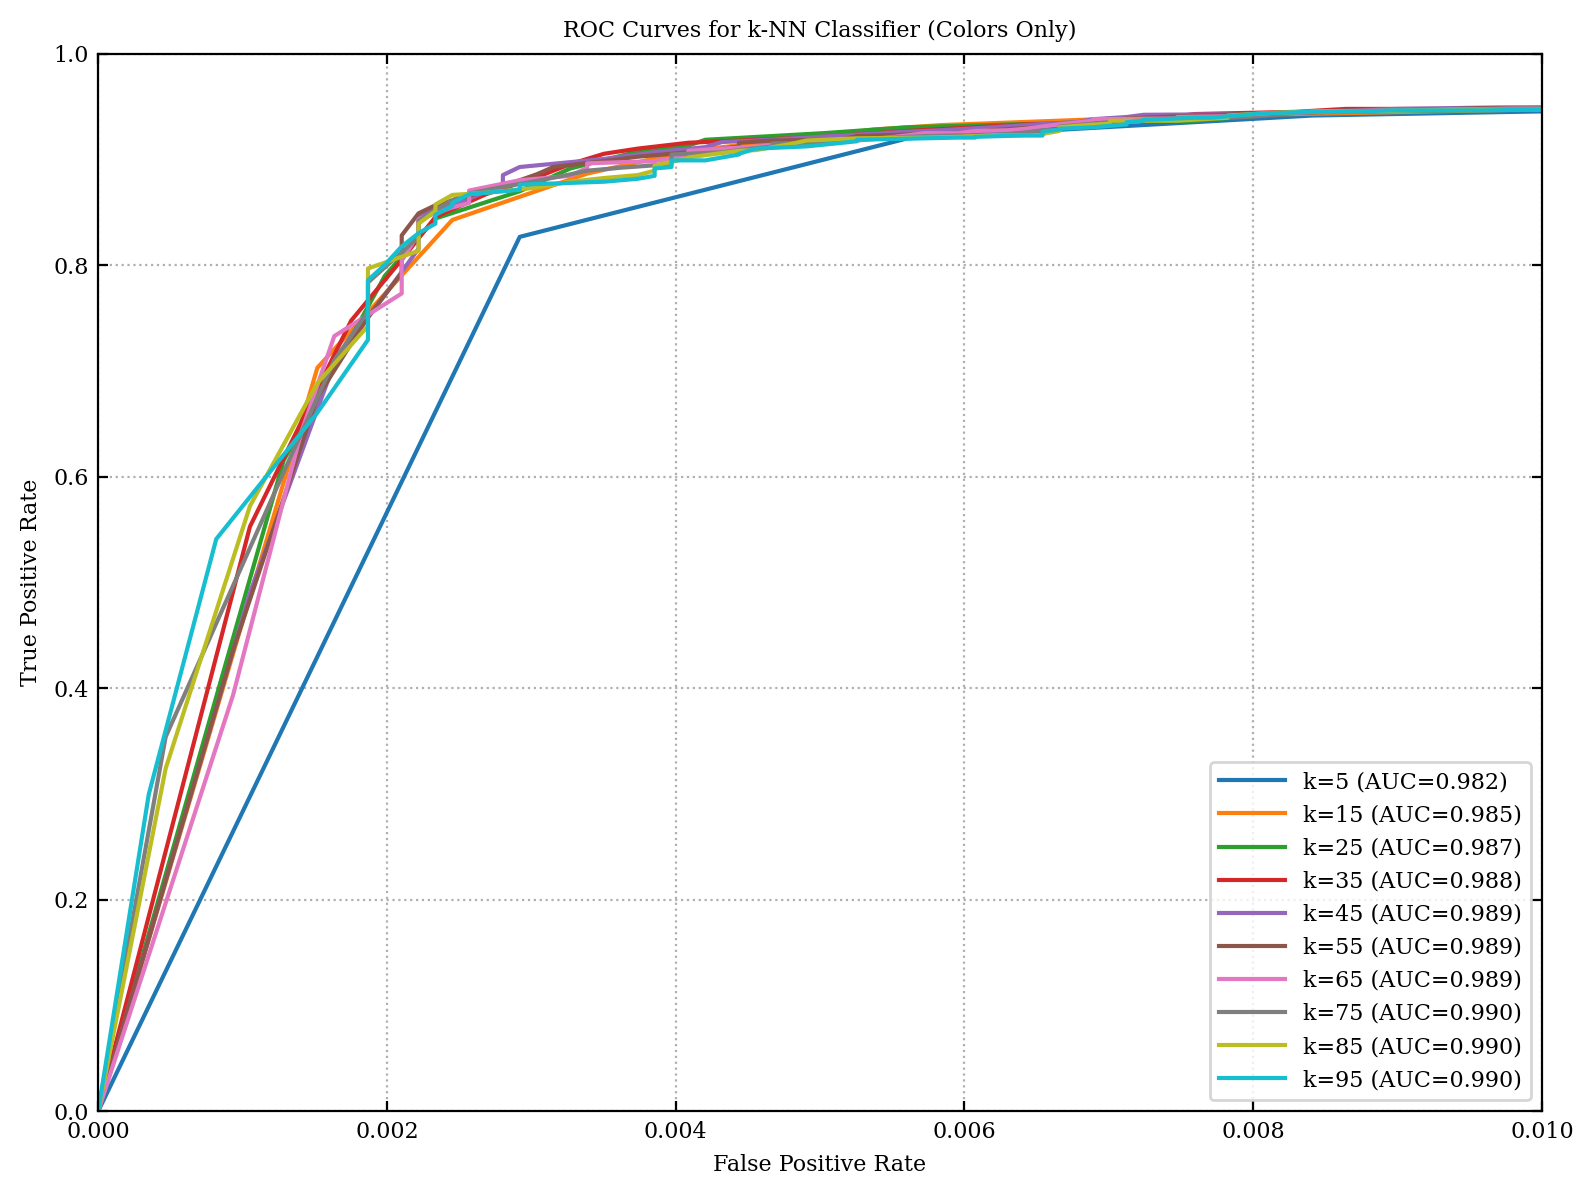

Best number of neighbors: 85 with AUC = 0.990


In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

k_values = range(5, 101, 10)
plt.figure(figsize=(8, 6))

best_auc = 0
best_k = 5

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(Xtrain_c, ytrain_c)
    
    # Predict probabilities for class 1 (quasar)
    quasar_index = np.where(clf.classes_ == 1)[0][0]
    y_prob = clf.predict_proba(Xtest_c)[:, quasar_index]
    
    fpr, tpr, _ = roc_curve(ytest_c, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'k={k} (AUC={roc_auc:.3f})')

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_k = k

plt.title("ROC Curves for k-NN Classifier (Colors Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best number of neighbors: {best_k} with AUC = {best_auc:.3f}")


I think it is funny that once we use more regourous and computationally advanced methods to when we can analize upwards of 100 classes we get a much steeper trus positive rate- ALC

7.)Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance.

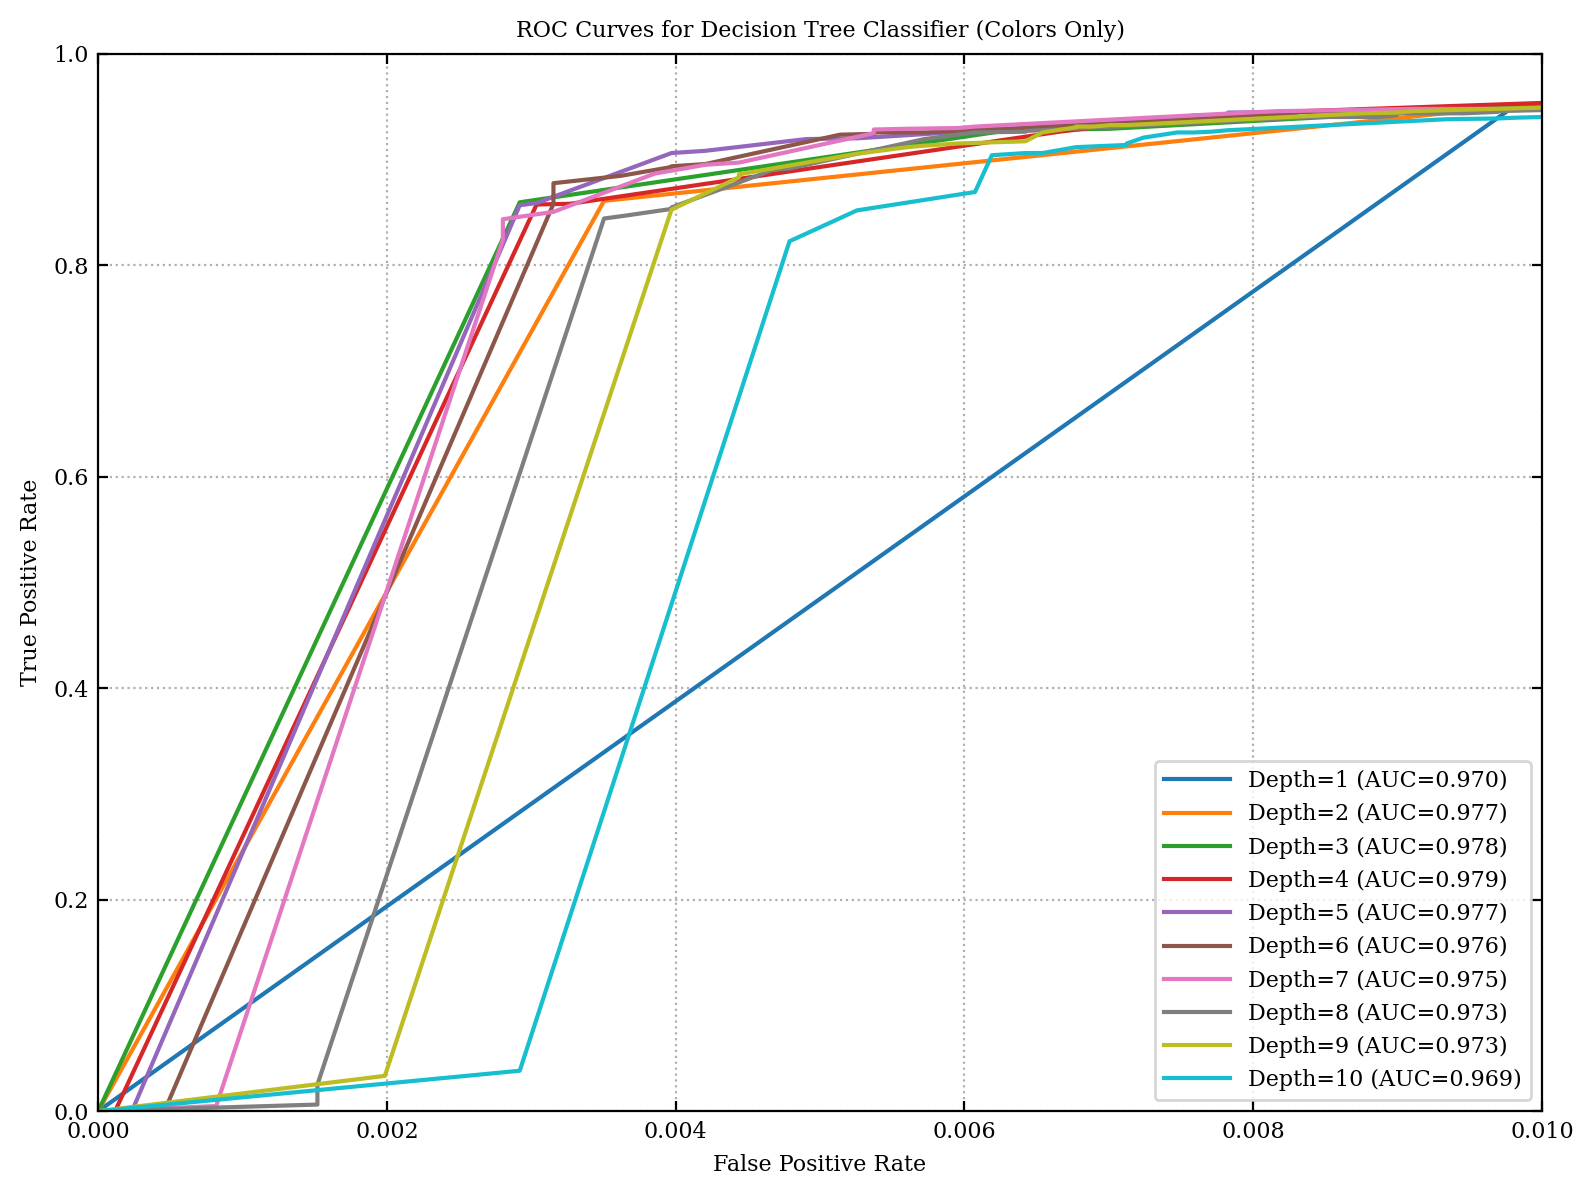

Best max depth: 4 with AUC = 0.979


In [69]:
from sklearn.tree import DecisionTreeClassifier

max_depth_values = range(1, 11)
plt.figure(figsize=(8, 6))

best_auc = 0
best_depth = 1

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(Xtrain_c, ytrain_c)
    
    # Predict probabilities for class 1 (quasar)
    quasar_index = np.where(clf.classes_ == 1)[0][0]
    y_prob = clf.predict_proba(Xtest_c)[:, quasar_index]
    
    fpr, tpr, _ = roc_curve(ytest_c, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Depth={max_depth} (AUC={roc_auc:.3f})')

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_depth = max_depth

plt.title("ROC Curves for Decision Tree Classifier (Colors Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best max depth: {best_depth} with AUC = {best_auc:.3f}")


It is not suprising that there is such spread, as tree classigiers are good for simple machine learning, learning exponentially as we inclread depth. -ALC

9.)Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier?




from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifiers = {
    "GNB": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "GMMBayes": GMMBayes(n_components=best_n),  
    "k-NN": KNeighborsClassifier(n_neighbors=best_k), 
    "Decision Tree": DecisionTreeClassifier(max_depth=best_depth) 
}

plt.figure(figsize=(8, 6))

# Loop over classifiers and plot ROC curves
best_auc = 0
best_classifier = None

for clf_name, clf in classifiers.items():
    # Fit classifier
    clf.fit(Xtrain_c, ytrain_c)

    # Get the probabilities for class 1 (quasar)
    quasar_index = np.where(clf.classes_ == 1)[0][0]
    y_prob = clf.predict_proba(Xtest_c)[:, quasar_index]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(ytest_c, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC={roc_auc:.3f})')

    # Track the best classifier
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_classifier = clf_name

# Final plot settings
plt.title("ROC Curves for Various Classifiers (Colors Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Output best classifier
print(f"Overall best-performing classifier: {best_classifier} with AUC = {best_auc:.3f}")

Huh... It looks like the k-NN has the best performing classifier.-ALC

10.)Make a 2-panel plot, showing in the left panel the color-coded training data in  versus  (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier.

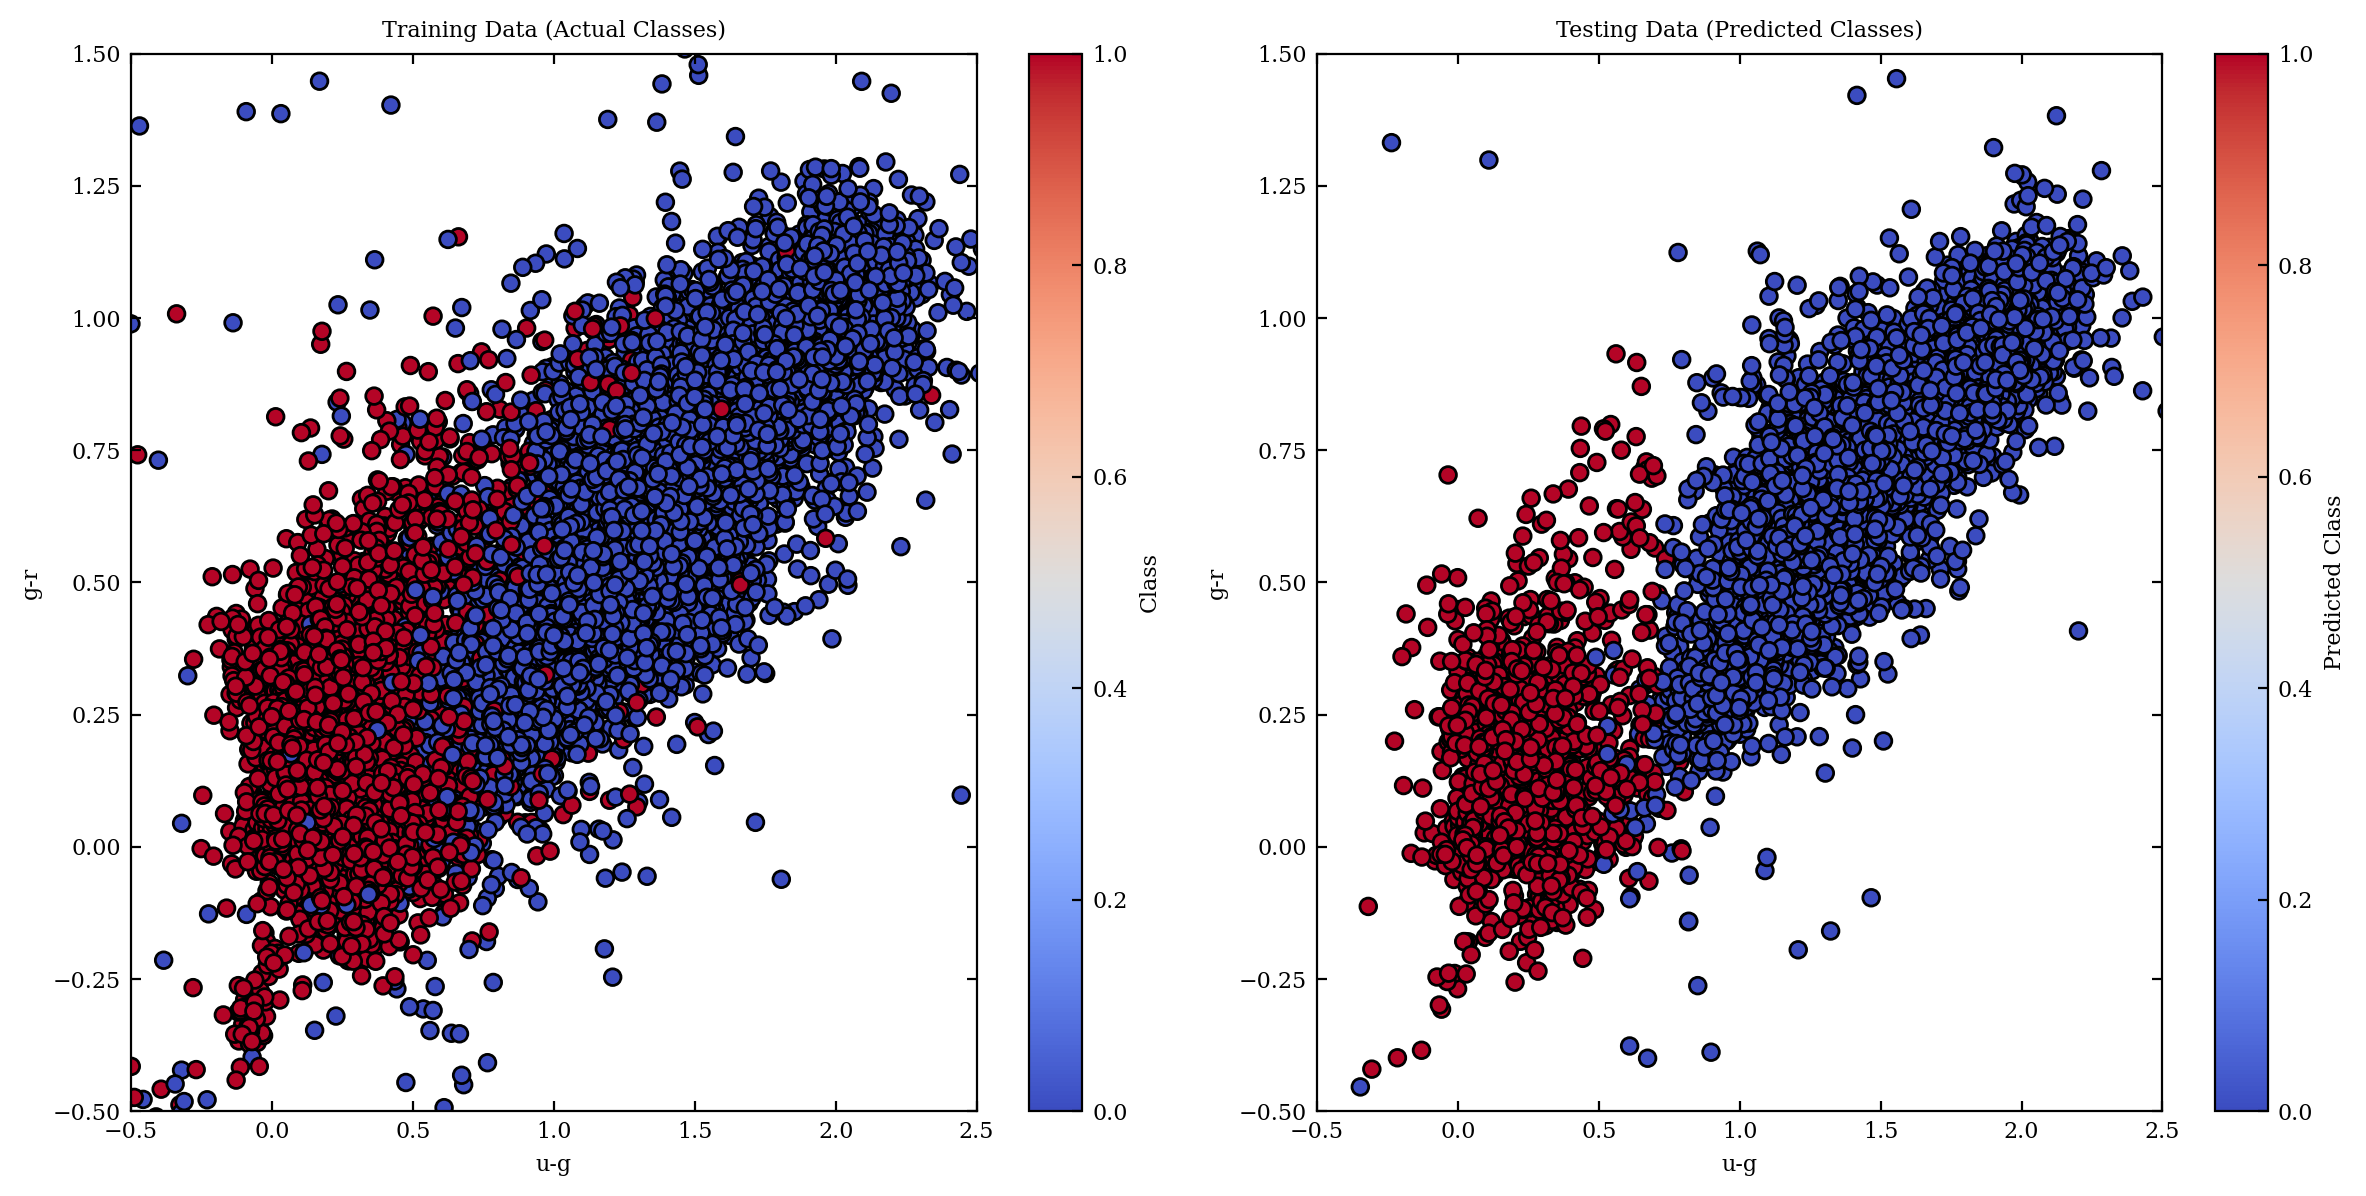

In [82]:


# Train the best-performing classifier (e.g., from previous tuning)
best_clf = classifiers["Decision Tree"]  # or any other classifier you've found to be best
best_clf.fit(Xtrain_c, ytrain_c)

# Predict the classes for the test data
y_pred = best_clf.predict(Xtest_c)

# Plot the figure with two panels
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Left Panel: Training data color-coded by actual class
scatter1 = ax[0].scatter(Xtrain_c[:, 0], Xtrain_c[:, 1], c=ytrain_c, cmap='coolwarm', edgecolors='k')
ax[0].set_title('Training Data (Actual Classes)')
ax[0].set_xlabel('u-g')
ax[0].set_ylabel('g-r')
ax[0].set_xlim(-0.5, 2.5)
ax[0].set_ylim(-0.5, 1.5)
fig.colorbar(scatter1, ax=ax[0], label='Class')

# Right Panel: Testing data color-coded by predicted class
scatter2 = ax[1].scatter(Xtest_c[:, 0], Xtest_c[:, 1], c=y_pred, cmap='coolwarm', edgecolors='k')
ax[1].set_title('Testing Data (Predicted Classes)')
ax[1].set_xlabel('u-g')
ax[1].set_ylabel('g-r')
ax[1].set_xlim(-0.5, 2.5)
ax[1].set_ylim(-0.5, 1.5)
fig.colorbar(scatter2, ax=ax[1], label='Predicted Class')

plt.tight_layout()
plt.show()


The way I understand this deata is that it gets better at predicting the classes/learning the data as I can see distinct binomality in the data!-ALC

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

Homework 8: Ayanah Cason

1)Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of , , , and  colors. Also create arrays of redshift and the spectral class.


In [58]:
sliced_data = data[::20]#Slice the data array to only take every other 10th row. 
ug_color = sliced_data['u'] - sliced_data['g']# ultraviolet to green
gr_color = sliced_data['g'] - sliced_data['r']#green to red
ri_color = sliced_data['r'] - sliced_data['i']#red to near-IR
iz_color = sliced_data['i'] - sliced_data['z']#near-IR to further-IR

#thats spectra!! -ALC

#Also create arrays of redshift and the spectral class.
specNames10th = sliced_data['specClass']
redshift10th = sliced_data['redshift']
redshift_err10th = sliced_data['redshift_err']

2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.

/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_20545/8349875.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_classes))  # You can change 'viridis' to any colormap you prefer


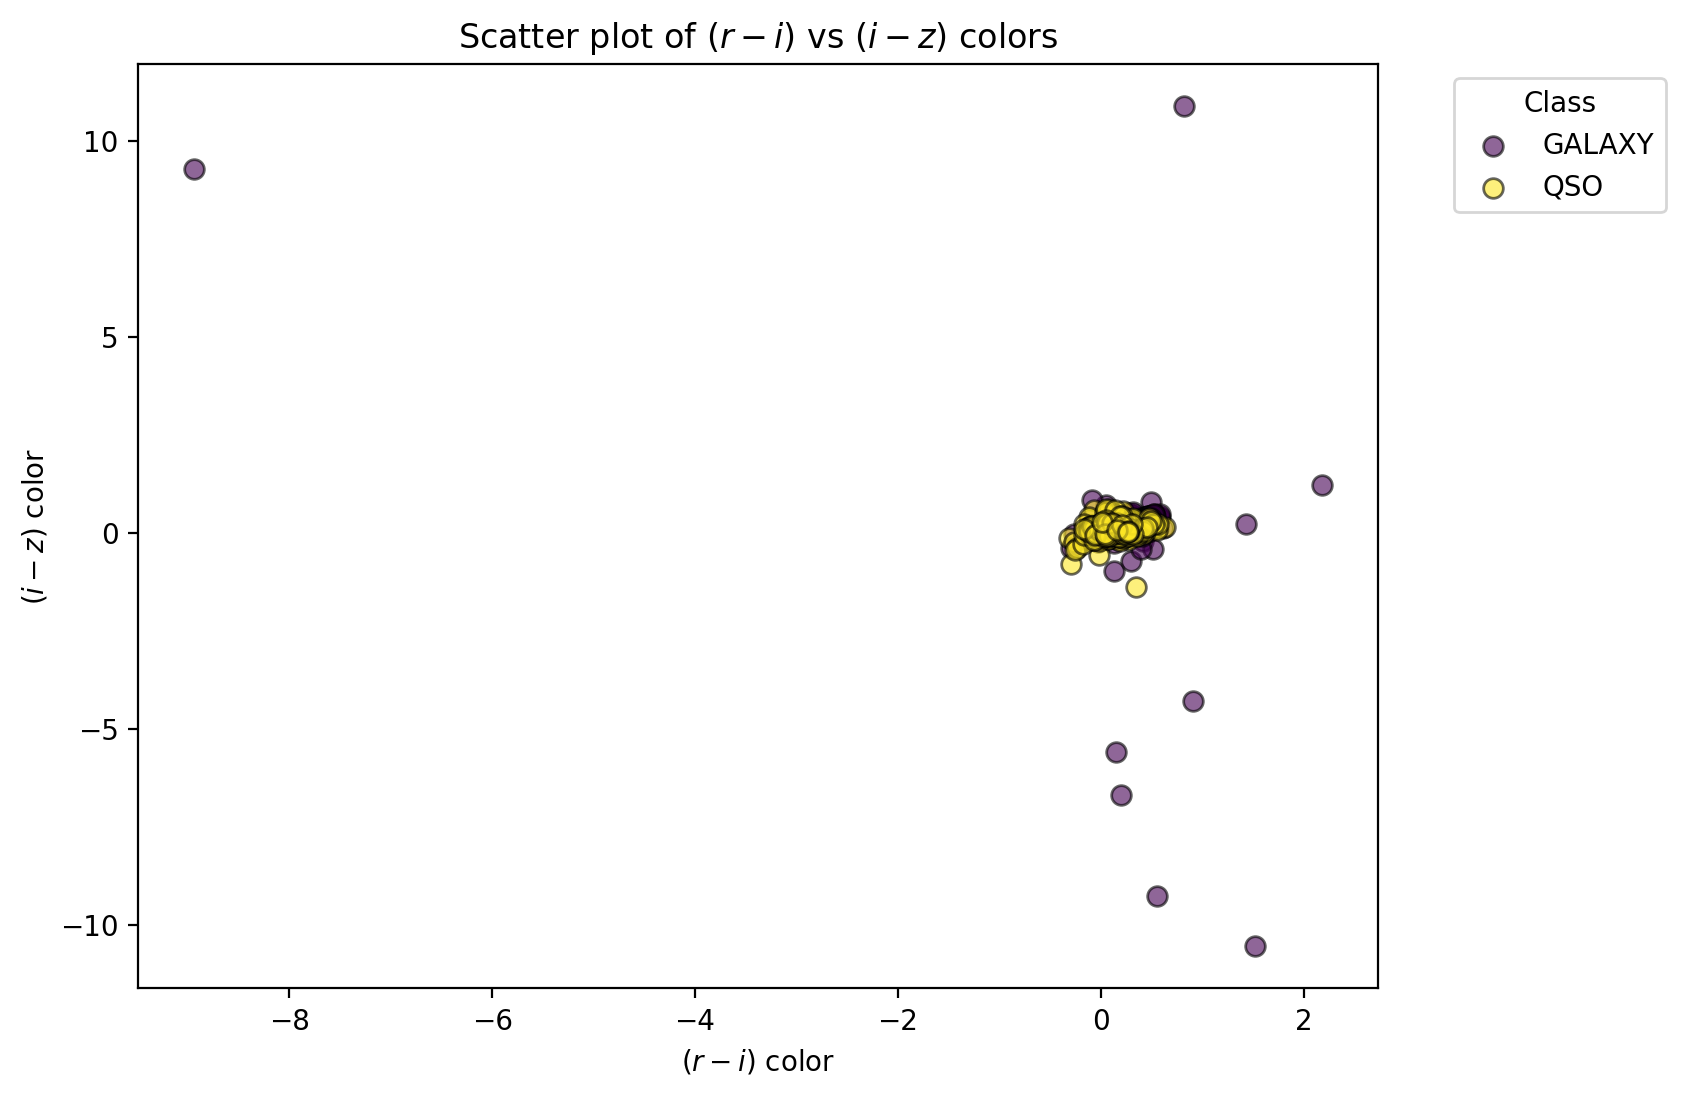

In [81]:
#Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class.

class_labels = sliced_data['specClass']  # Using the 'specClass' field for class labels

# Create a list of unique class labels
unique_classes = np.unique(class_labels)

# Define a color map
colors = plt.cm.get_cmap('viridis', len(unique_classes))  # You can change 'viridis' to any colormap you prefer

# Plot
plt.figure(figsize=(8, 6))

# Scatter plot, color by class
for idx, class_label in enumerate(unique_classes):
    class_mask = class_labels == class_label
    plt.scatter(ri_color[class_mask], iz_color[class_mask], 
                label=class_label, 
                alpha=0.6, 
                color=colors(idx), 
                edgecolors='k', 
                s=50)

# Labels and title
plt.xlabel(r'$(r - i)$ color')
plt.ylabel(r'$(i - z)$ color')
plt.title('Scatter plot of $(r - i)$ vs $(i - z)$ colors')

# Add a legend
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Cool. I don't prefer the color combination, but I assume it is a good color contrast -ALC

/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_20545/3881434516.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_classes))  # Or try 'tab10' for clearer class distinction


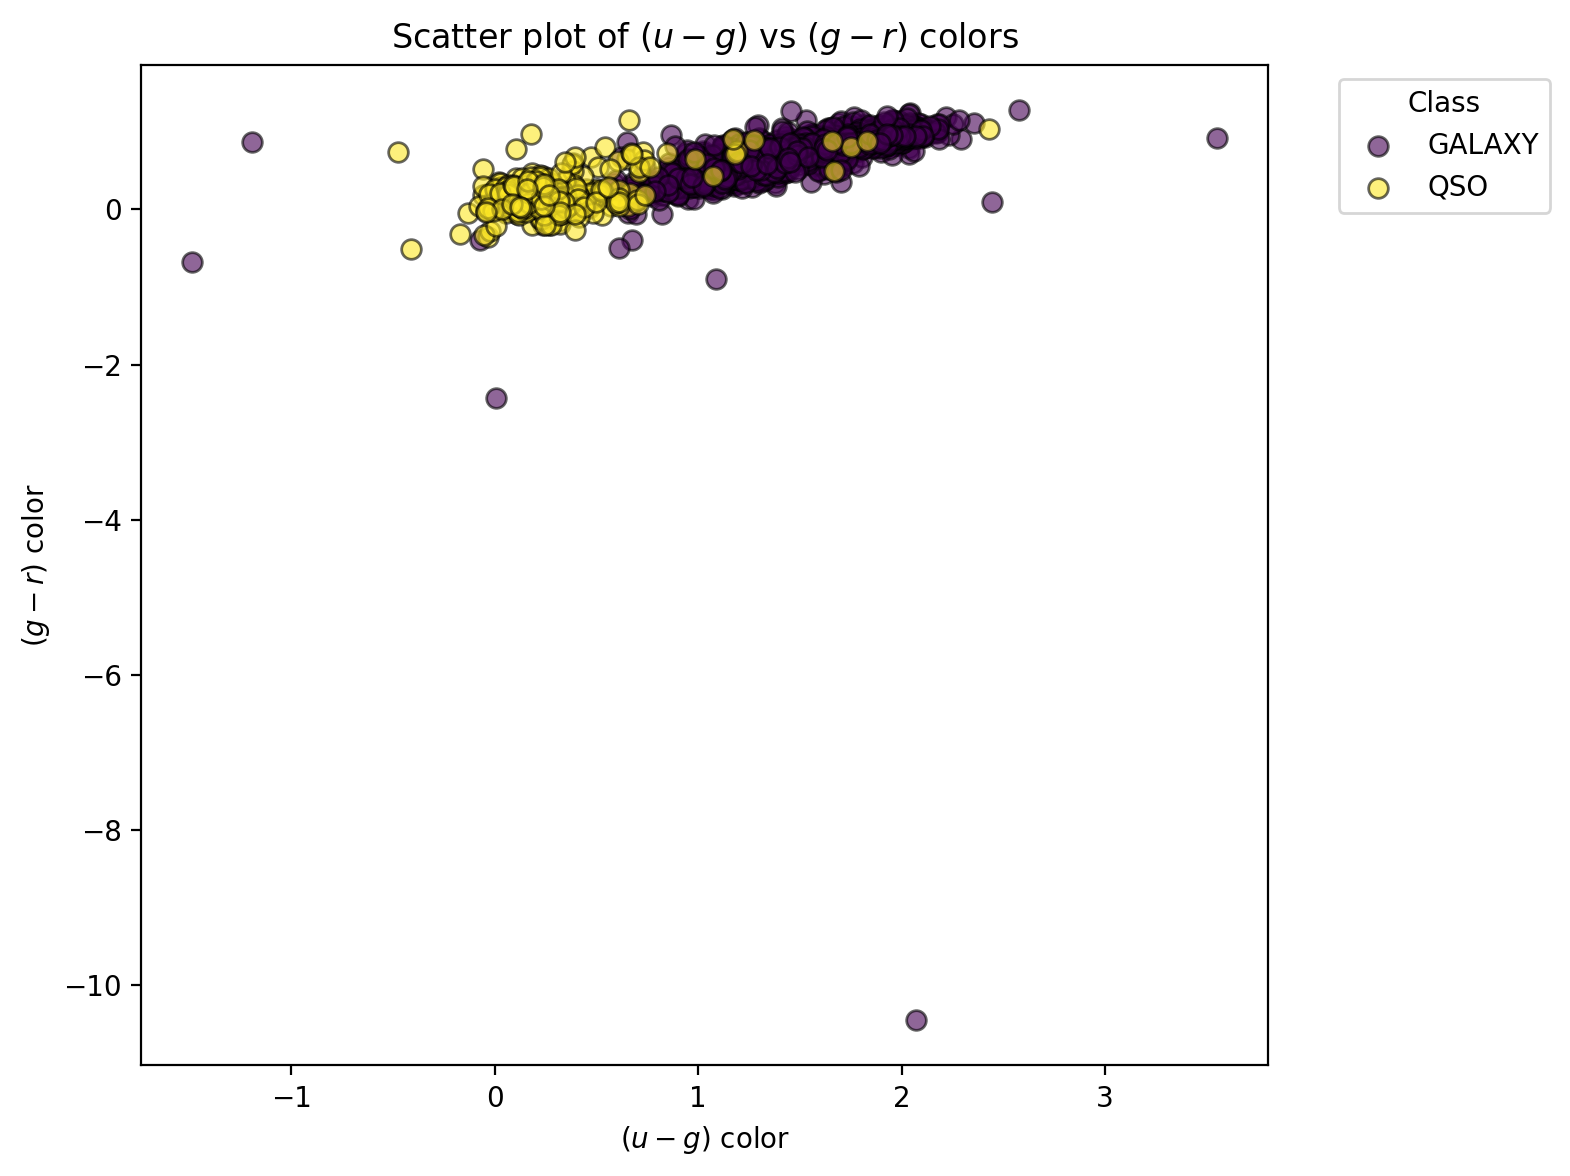

In [85]:
sliced_data = data[::20]

# Calculate the (u - g) and (g - r) colors
ug_color = sliced_data['u'] - sliced_data['g']
gr_color = sliced_data['g'] - sliced_data['r']

class_labels = sliced_data['specClass']  

# Unique classes for color coding
unique_classes = np.unique(class_labels)
colors = plt.cm.get_cmap('viridis', len(unique_classes))  

# Plot
plt.figure(figsize=(8, 6))

# Scatter plot by class
for idx, class_label in enumerate(unique_classes):
    class_mask = class_labels == class_label
    plt.scatter(ug_color[class_mask], gr_color[class_mask], 
                label=class_label, 
                alpha=0.6, 
                color=colors(idx), 
                edgecolors='k', 
                s=50)

# Labels and title
plt.xlabel(r'$(u - g)$ color')
plt.ylabel(r'$(g - r)$ color')
plt.title('Scatter plot of $(u - g)$ vs $(g - r)$ colors')
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$.


 Yeah. I see. -alc

3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


In [93]:
# Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$.
color_matrix = np.column_stack((ug_color, gr_color, ri_color, iz_color))
color_feature_names = ['u-g', 'g-r', 'r-i', 'i-z']

print("Color matrix shape:", color_matrix.shape)
print("First 5 rows:\n", color_matrix[:5])

#Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar.
class_labels = sliced_data['specClass']
target_labels = np.array([1 if cls == 'QSO' else 0 for cls in class_labels])
print("Label counts:", np.unique(target_labels, return_counts=True))

#Perform a train-test split, taking $20\%$ of the data for testing.
from sklearn.model_selection import train_test_split

X = color_matrix
y = target_labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Set the `random_state` in your train-test split to be `42` for reproducibility

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))

Color matrix shape: (2500, 4)
First 5 rows:
 [[0.57029 0.04138 0.02815 0.28811]
 [0.14604 0.15181 0.15165 0.21238]
 [1.19674 0.5792  0.39452 0.24098]
 [1.11679 0.52154 0.33345 0.16927]
 [1.94691 0.95409 0.52665 0.47079]]
Label counts: (array([0, 1]), array([2130,  370]))
Training data shape: (2000, 4)
Test data shape: (500, 4)
Training label distribution: [1696  304]
Test label distribution: [434  66]



4. Scale your training and testing data to prepare it for the DNN. 



In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


In [109]:
#Train scikit-learn's multi-layer perceptron classifier with ReLU activation,

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,),  # you can adjust layer size/structure
                    activation='relu',          # ReLU activation
                    solver='adam',              # Optimizer
                    max_iter=500,               # Max number of iterations
                    random_state=42)            # For reproducibility

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)



#, stochastic gradient descent

mlp_sgd = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two layers: 64 neurons, then 32 neurons
    activation='relu',            # ReLU activation
    solver='sgd',                 # Stochastic Gradient Descent
    max_iter=1000,                # Max iterations
    random_state=42               # Reproducibility
)

# Train the model
mlp_sgd.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_sgd = mlp_sgd.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_sgd)
report = classification_report(y_test, y_pred_sgd)

print(f"SGD MLP Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Test Accuracy: 0.9800
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       434
           1       0.91      0.94      0.93        66

    accuracy                           0.98       500
   macro avg       0.95      0.96      0.96       500
weighted avg       0.98      0.98      0.98       500

SGD MLP Test Accuracy: 0.9800
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       434
           1       0.92      0.92      0.92        66

    accuracy                           0.98       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.98      0.98      0.98       500



So for the a ReLU activation has a 91% precision and a 94%recall whereas the sdg has higer precision but 92% recall. - ALC

6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.

In [118]:
from sklearn.model_selection import GridSearchCV

parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    solver='sgd',
    activation='relu',
    max_iter=1000,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=parameters,
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,              # Use all available CPU cores
    verbose=2               # Print progress
)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

from sklearn.metrics import classification_report
print("Test Set Performance:\n")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

Test Set Performance:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       434
           1       0.92      0.89      0.91        66

    accuracy                           0.98       500
   macro avg       0.95      0.94      0.95       500
weighted avg       0.98      0.98      0.98       500



The GridSearchCV optimization has slightly improved the balance in terms of recall and F1-score -ALC

7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

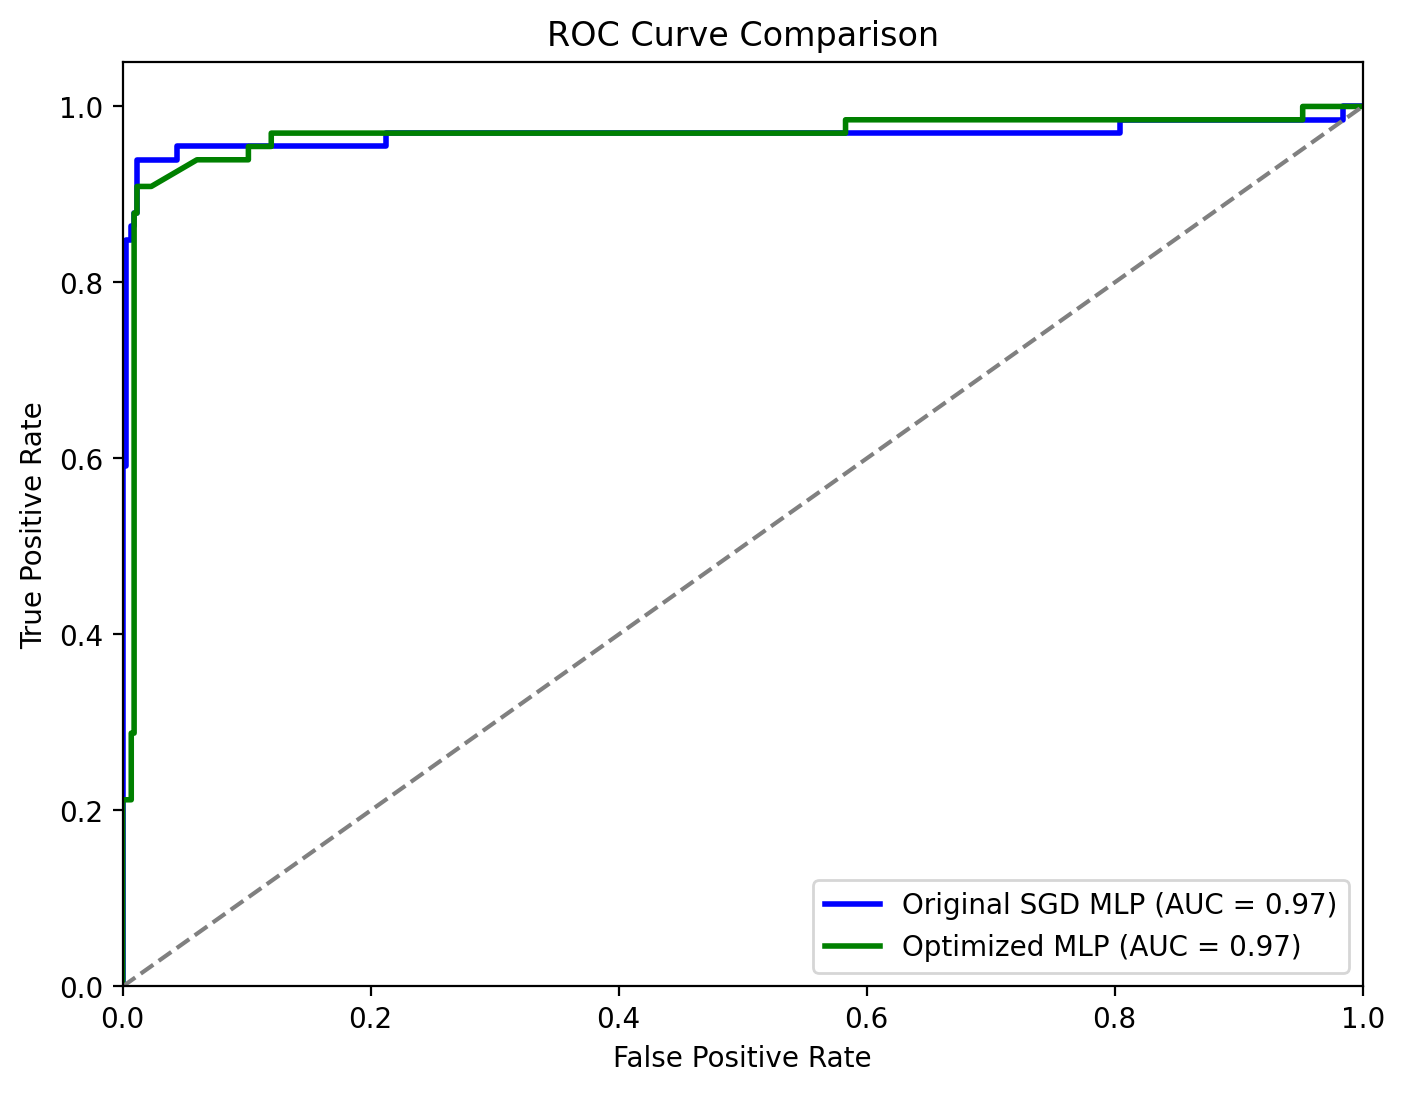

In [134]:
best_mlp_model = grid_search.best_estimator_

# Fit the model (though it's already fitted in GridSearch, just ensuring it's used)
best_mlp_model.fit(X_train_scaled, y_train)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for both models
y_pred_prob_sgd = mlp_sgd.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1
y_pred_prob_best = best_mlp_model.predict_proba(X_test_scaled)[:, 1]  
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_prob_sgd)  # this shows how well the model discriminates 
                                                        #between the two classes as you adjust the classification threshold.
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_prob_best)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8, 6))

# Plot ROC curve for the original SGD model
plt.plot(fpr_sgd, tpr_sgd, color='blue', lw=2, label=f'Original SGD MLP (AUC = {roc_auc_sgd:.2f})')

# Plot ROC curve for the optimized GridSearch model
plt.plot(fpr_best, tpr_best, color='green', lw=2, label=f'Optimized MLP (AUC = {roc_auc_best:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')

# Show the plot
plt.show()

This is cool. I had to look up some of the interpretations. I am positive in this model as the ramdo classifier line and that curve comparision do not match at all. This means that the neural networks are reliable predicting power.   -ALC